Refer this video first https://www.youtube.com/watch?v=5WoItGTWV54 by Fei-Fei Li

'''Example of VAE on MNIST dataset using MLP
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to  generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean=0 and std=1.'''

# References
[1] Kingma, Diederik P., and Max Welling.
"Auto-encoding variational bayes."

https://arxiv.org/abs/1312.6114


[2] https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/  (Mathematical understanding of VAEs and its loss functions)

[3] https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py  (Took base code from here)

[4] https://blog.keras.io/building-autoencoders-in-keras.html  (Optional)

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os



C:\Users\kmura\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Reparameterization trick
 Instead of sampling from Q(z|X), we sample using eps = N(0,I)
 z = z_mean + sqrt(var)*eps

Simple and insightful explanation can be found here
https://www.quora.com/What-is-the-reparameterization-trick-in-variational-autoencoders

VAE has encoder and decoder. Decoder randomly samples from true posterior Z~ q(z∣ϕ,x). To implement encoder and decoder as a neural network, you need to backpropogate through random sampling and that is the problem because backpropogation cannot flow through random node; to overcome this obstacle, we use reparameterization trick .

Now lets come to trick. Since our posterior is normally distributed, we can approximate it with another normal distribution . We approximate Z with normally distributed ε.

In [3]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    # Latent variable z = z_mean + z_sigma*eps

    # z_log_var is log(sigma^2) and K.exp(0.5 * z_log_var) converts log(sigma^2) to sigma
    # Link for different types
    #of variance formshttps://math.stackexchange.com/questions/2540170/reparameterization-trick-for-gaussian-distribution

    z_mean, z_log_var = args
    
    batch = K.shape(z_mean)[0]

    dim = K.int_shape(z_mean)[1]
    
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



In [4]:



def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()



In [5]:

# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


In [11]:
x_train.shape

(60000, 784)

In [6]:

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 64
latent_dim = 2
epochs = 50


In [12]:

# VAE model = encoder + decoder

################################ encoder--start  ####################

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)



################################ encoder--end  ####################

################################ decoder--start  ####################

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

################################ decoder--end  ####################



# instantiate VAE model
outputs = decoder(encoder(inputs)[2])  #encoder(inputs)[2] is  Z~ q(z∣ϕ,x)
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [8]:
ltype='centropy'
lweights = 'no' # Load _weights
weights='null' #weights_path


For KL Divergence and its loss function, refer to 
https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/

Probably the best blog I've ever seen!

### VAE loss = (mse_loss // xent_loss) + kl_loss


In [9]:


models = (encoder, decoder)
data = (x_test, y_test)




# VAE loss = mse_loss or xent_loss + kl_loss

if ltype=='mse':
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs,outputs)
    
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)  
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5


vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)


vae.compile(optimizer='adam')
vae.summary()




plot_model(vae,to_file='vae_mlp.png',show_shapes=True)

if lweights=='load':
    vae.load_weights(weights)
else:
    # train the autoencoder
    vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))
#     vae.save_weights('vae_mlp_mnist.h5')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 149us/step - loss: 185.1567 - val_loss: 169.1897
Epoch 2/50
60000/60000 [==============================] - 5s 90us/step - loss: 167.4157 - val_loss: 165.1733
Epoch 3/50
60000/60000 [==============================] - 5s 88us/step - loss: 164.1627 - val_loss: 163.1968
Epoch 4/50
60000/60000

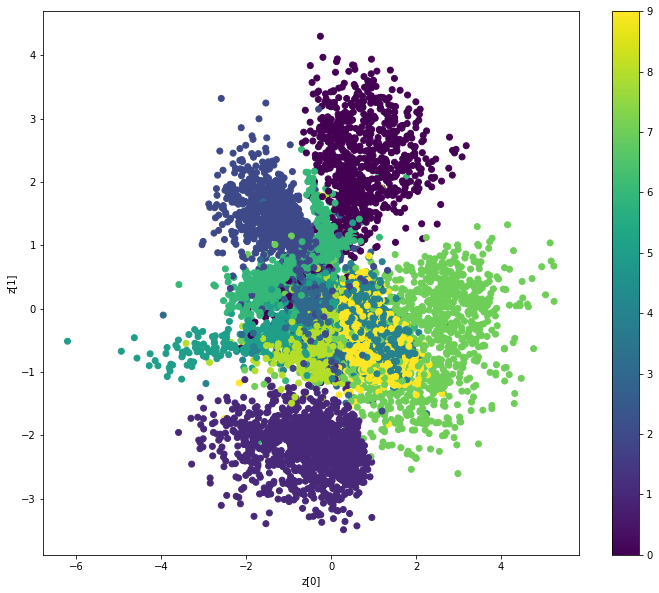

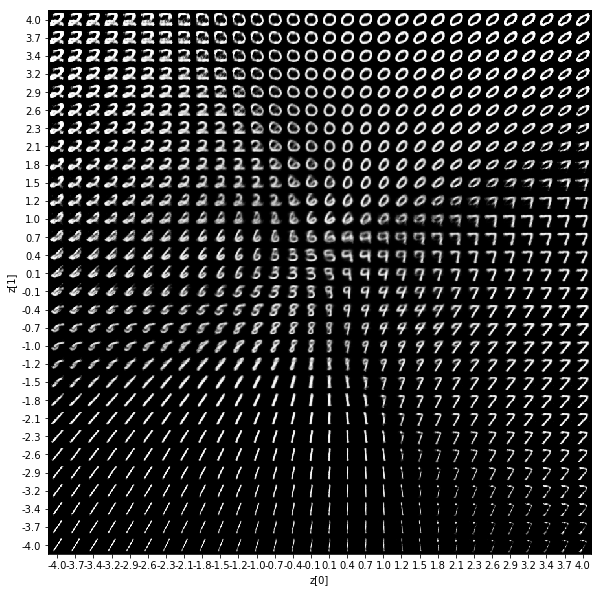

In [10]:
plot_results(models,data,batch_size=batch_size,model_name="vae_mlp")